In [1]:
from functions import *
from models import *

2024-11-13 10:37:10.959704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 10:37:10.988349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 10:37:10.997317: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 10:37:11.020288: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 10:37:12.374795: W tensorflow/compiler/tf2

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import time
from datetime import datetime
from collections import Counter
from multiprocessing import Pool
import gc

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Load data

In [4]:
source_folder = '../data/external/raster_masks'
rivers = {}
source_path = '../data/preprocessed/'
data_paths = ['lst','slope', 'discharge', 'ndvi','altitude']#, 'ndvi', 'wt', 'masked','discharge', 'slope']#, 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {k:[] for k in data_paths}    
total_data = {}
total_times = {}
complete_rivers = []
filter_river = None
W=256
time_split = False


In [5]:
filepaths = [os.path.join(source_folder, f) for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]
with Pool() as pool:
    river_data = pool.map(load_river_raster, filepaths)
    rivers = {name: data for name, data in river_data}


# Load input paths
for i,dir_p in enumerate(dir_paths):
    if data_paths[i] != 'discharge' and data_paths[i] != 'slope' and data_paths[i] != 'altitude':
        imgs_per_river = Counter()
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints'): 
            all_dir_paths[data_paths[i]].append(subdir)
        elif subdir.endswith('masked') and 'masked' in data_paths:
            all_dir_paths['masked'].append(subdir)
        elif dir_p.endswith('altitude'):
            all_dir_paths[data_paths[i]].extend(files)
            
# Load input data
for k,v in all_dir_paths.items():
    if filter_river != None:
        v = [v[i] for i in filter_river]
    
    if k != 'discharge' and k != 'slope' and k != 'altitude':
        if k == 'lst' or k == 'masked':
            list_rgb = [True]*len(v)
        else:
            list_rgb = [False]*len(v)
            
        data, times = load_data(v,W,list_rgb)
        if k!='masked':
            labels = []
            for ki,value in data.items():
                labels+=[ki.split('/')[-1]]*len(value)
        
        data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
        times_list = [t for sublist in times for t in sublist]
   
        if time_split:
            dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
            pairs = sorted(zip(dates, data_values, labels), key=lambda x: x[0])
            sorted_dates, data_values, labels = zip(*pairs)
            times_list = [date.strftime('%Y-%m') for date in sorted_dates]
            
        total_data[k] = np.array(data_values)
        total_times[k] = times_list
        print(k,':' ,total_data[k].shape)


for k,v in all_dir_paths.items():
    total = []
    if k == 'discharge' or k == 'slope' or k == 'altitude':
        imgss = {}
        for i,lab in enumerate(labels):
            for file in v:
                if lab == file.split('/')[-1] or lab == file.split('.')[0]:
                    if lab not in imgss.keys():
                        if k != 'altitude':
                            file_path = os.path.join(file,os.listdir(file)[0])
                        else:
                            file_path = os.path.join('../data/preprocessed/altitude', file)
                        
                        r,m = load_raster(file_path, False)
                        var = resize_image(r, W,W)
                        var = np.where(np.isnan(var), 0.0, var)

                        imgss[lab] = var
                    else:
                        var = imgss[lab]
                    total.append(var)
                        
        total_data[k] = np.array(total)
        print(k, np.array(total).shape)


# Load cos and sin variables
str_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


# Load target variable
water_temp = pd.read_csv('../data/preprocessed/wt/water_temp.csv', index_col=0)
times_ordered = total_times['lst']
wt_temp=[]
for cell, date in zip(labels,times_ordered):
    temp = water_temp[(water_temp["Cell"] == cell) & (water_temp["Date"] == date)]["WaterTemp"]
    if not temp.empty:
        wt_temp.append(temp.values[0])
data_targets = np.array(wt_temp)


lst : (955, 256, 256, 3)
ndvi : (955, 256, 256)
slope (955, 256, 256)
discharge (955, 256, 256)
altitude (955, 256, 256)


### Concatenate additional inputs

#### Vectorize dates

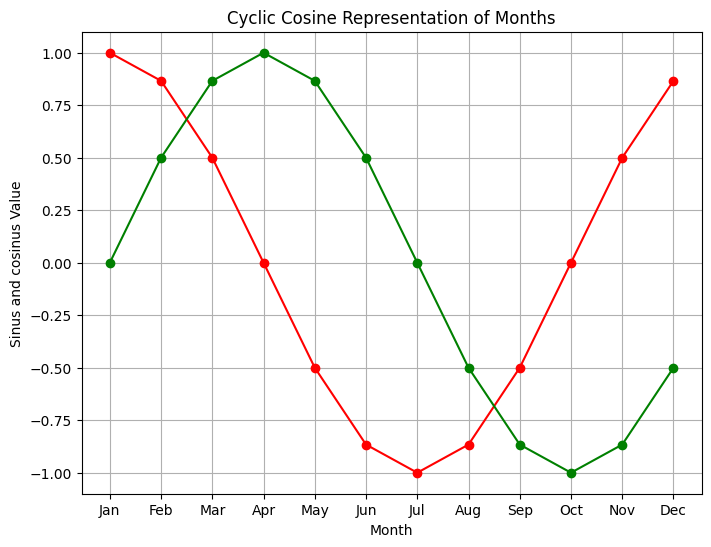

In [6]:
import numpy as np

def get_months_vectorized(times):
    """
    Calculate the cosine and sine values for each month in a given list of dates.
    Additionally, return a dictionary that maps each unique cosine value to its corresponding month.
    
    Parameters:
    ----------
    times : list or array-like
        A list of date strings or datetime objects from which month information is extracted.
        
    Returns:
    -------
    cosine_months : np.ndarray
        An array of cosine values corresponding to each month in the `times` input.
        
    sine_months : np.ndarray
        An array of sine values corresponding to each month in the `times` input.
        
    cos_to_month : dict
        A dictionary where each key is a unique cosine value and the corresponding value is the month (1-12) 
        associated with that cosine value."""
    
    month_cosine_dict = {month: np.cos((month - 1) / 12 * 2 * np.pi) for month in range(1, 13)}
    month_sinus_dict = {month: np.sin((month - 1) / 12 * 2 * np.pi) for month in range(1, 13)}
    
    cos_to_month = {cos_val: month for month, cos_val in month_cosine_dict.items()}
    
    def cosine_for_month(month):
        return month_cosine_dict[month]

    def sine_for_month(month):
        return month_sinus_dict[month]

    cosine_vectorized = np.vectorize(cosine_for_month)
    sine_vectorized = np.vectorize(sine_for_month)

    times_dt = pd.to_datetime(times)
    months = times_dt.month

    cosine_months = cosine_vectorized(months)
    sine_months = sine_vectorized(months)
    
    return cosine_months, sine_months, cos_to_month

month_cosine_dict = {month: np.cos((month - 1) / 12 * 2 * np.pi) for month in range(1, 13)}
month_sinus_dict = {month: np.sin((month - 1) / 12 * 2 * np.pi) for month in range(1, 13)}
    
months = list(month_cosine_dict.keys())
cosine_values = list(month_cosine_dict.values())
sinus_values = list(month_sinus_dict.values())
str_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(8, 6))
plt.plot(months, cosine_values, marker='o',color='red')
plt.plot(months, sinus_values, marker='o',color='green')
plt.xticks(months, str_months)
plt.xlabel('Month')
plt.ylabel('Sinus and cosinus Value')
plt.title('Cyclic Cosine Representation of Months')
plt.grid(True)
plt.show()


In [7]:
cosine_months, sine_months, cos_to_month = get_months_vectorized(total_times['lst'])
print(len(cosine_months),len(sine_months))

955 955


#### Vectorize lat and lon

In [8]:
file_path = '../data/raw/wt/cell_coordinates.csv'
lat_lon = pd.read_csv(file_path)
lat_lon

,Cell,Latitude,Longitude
0,1,2656959,1259353.0
1,2,2733557,1118162.0
2,3,2629128,1140919.0
3,4,2734998,1182035.0
4,5,2623616,1200426.0
...,...,...,...
75,77,2611732,1272316.0
76,78,2604814,1192679.0
77,79,2658557,1218252.0
78,80,2561671,1187319.0


In [9]:
len(labels)
lats=[]
lons=[]
for label in labels:
    num_cell = int(label.split('_')[-1])
    lat = lat_lon[lat_lon.Cell==num_cell].Latitude.values[0]
    lon = lat_lon[lat_lon.Cell==num_cell].Longitude.values[0]
    lats.append(lat)
    lons.append(lon)
lats = np.array(lats)
lons = np.array(lons)
print(len(lats),len(lons))

955 955


In [10]:
additional_inputs = np.column_stack((cosine_months, sine_months, lats, lons))

## Do experiment

### Parameters

In [11]:
W = 256
filter_river = None#[3,11,12]
inputs = ['lst']#,'slope', 'discharge','ndvi']#,'discharge', 'slope','altitude']#['ndvi','discharge', 'slope']
conditioned = True
batch_size = 64
epochs = 300
model_name = "baseline_CNN" #img_wise_CNN, UNet, transfer_learning_VGG16, CNN, img_2_img
stratified = False
physics_guided = False

#### Adapt inputs shape

In [12]:
# Choose inputs
inputs_d = [total_data[inp] for inp in inputs]
# List to store the processed additional images
expanded_images = []
# Expand dimensions for single-channel images, leave multi-channel images as they are
for img in inputs_d:
    if img.ndim == 3:  # Case where image is (n, 256, 256) (single-channel)
        expanded_images.append(np.expand_dims(img, axis=-1))  # Expand to add an extra channel
    elif img.ndim == 4:  # Case where image already has multiple channels (n, 256, 256, c)
        expanded_images.append(img)  # Leave the image as it is
# Concatenate all images along the last axis (channels)
combined_input = np.concatenate(expanded_images, axis=-1)
# The final combined input is stored in input_data
input_data = combined_input

### Split data

In [13]:
if time_split:
    train_ratio = 0.6
    val_ratio = 0.2
    test_ratio = 0.2
    
    # Calcular el tamaño de cada conjunto
    total_images = len(input_data)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)
    indices = np.arange(total_images)
    
    train_index = indices[:train_size]                       # Primeros índices para entrenamiento
    validation_index = indices[train_size:train_size + val_size]    # Siguientes índices para validación
    test_index = indices[train_size + val_size:]             # Últimos índices para prueba
       
elif stratified:
    train_index, validation_index, test_index = split_data_stratified(input_data, data_targets, labels)
else:
    train_index, validation_index, test_index = split_data(input_data, data_targets)
            
validation_input = input_data[validation_index, :] / 255.0  # Normalize inputs
validation_target = data_targets[validation_index]
test_input = input_data[test_index, :] / 255.0  # Normalize inputs
test_target = data_targets[test_index]
train_input = input_data[train_index, :] / 255.0  # Normalize inputs
train_target = data_targets[train_index]

additional_inputs_train = additional_inputs[train_index, :]
additional_inputs_validation = additional_inputs[validation_index, :]
additional_inputs_test = additional_inputs[test_index, :]

print(f"Train: {len(train_input)} imágenes, {train_input.shape}")
print(f"Val: {len(validation_input)} imágenes, {validation_input.shape}")
print(f"Test: {len(test_input)} imágenes, {test_input.shape}")
print(f" Additional inputs {additional_inputs.shape}")
print(train_target.shape, validation_target.shape, test_target.shape)

train_dates = np.array(total_times['lst'])[train_index] 
validation_dates = np.array(total_times['lst'])[validation_index] 
test_dates = np.array(total_times['lst'])[test_index] 

Train: 765 imágenes, (765, 256, 256, 3)
Val: 95 imágenes, (95, 256, 256, 3)
Test: 95 imágenes, (95, 256, 256, 3)
 Additional inputs (955, 4)
(765,) (95,) (95,)


In [14]:
print(train_dates)
print(validation_dates)
print(test_dates)

['2013-08' '2013-12' '2015-02' '2015-07' '2015-08' '2016-05' '2016-11'
 '2017-04' '2017-11' '2018-04' '2018-09' '2018-10' '2019-01' '2019-04'
 '2019-09' '2020-04' '2020-10' '2021-03' '2021-04' '2021-10' '2021-11'
 '2022-02' '2022-11' '2023-02' '2023-03' '2023-11' '2014-12' '2015-03'
 '2015-10' '2017-07' '2017-10' '2018-02' '2018-05' '2019-04' '2023-10'
 '2024-05' '2015-05' '2017-08' '2018-07' '2018-09' '2019-11' '2022-01'
 '2023-08' '2023-11' '2023-12' '2024-01' '2024-02' '2013-11' '2014-07'
 '2019-02' '2019-07' '2019-08' '2021-06' '2022-05' '2013-09' '2014-04'
 '2015-03' '2016-11' '2017-06' '2017-11' '2018-01' '2018-02' '2018-03'
 '2018-05' '2018-11' '2020-04' '2022-01' '2022-06' '2023-07' '2016-06'
 '2016-10' '2017-11' '2018-01' '2018-04' '2018-05' '2019-09' '2020-02'
 '2022-09' '2013-03' '2013-06' '2013-10' '2014-01' '2014-03' '2014-05'
 '2015-09' '2016-03' '2016-09' '2016-11' '2017-02' '2017-04' '2017-05'
 '2018-05' '2018-07' '2018-08' '2018-10' '2018-11' '2018-12' '2019-02'
 '2019

#### Select inputs and model

In [15]:
if len(train_input.shape) == 3:
    input_shape = train_input.shape[1:]+(1,)
else:
    input_shape = train_input.shape[1:]
    
# Adapt input to condition
if conditioned:
    input_args = (input_shape, additional_inputs.shape[1])
    model_input = [train_input, additional_inputs_train]
    val_model_input = [validation_input, additional_inputs_validation]
    test_model_input = [test_input, additional_inputs_test]

else:
    input_args = input_shape
    model_input = train_input
    val_model_input = validation_input
    test_model_input = test_input

print(len(model_input))
    

2


In [16]:
# Start model
start_time = time.time()
if model_name == "baseline_CNN":
    if conditioned:
        model = build_cnn_model_features(input_args[0], input_args[1])
    else:
        model = build_cnn_baseline(input_args)
elif model_name == 'CNN':
    model = build_cnn_model(input_args)
elif model_name == 'img_2_img':
    model = build_img_2_img_model(input_args)
elif model_name == 'UNet':
    model = build_unet(input_args)
elif model_name == 'transfer_learning_VGG16':
    train_input = train_input[:, :, :, :3]
    model = build_transfer_model((W, W, 3))
elif model_name == "img_wise_CNN_improved":
    model = build_simplified_cnn_model_improved(input_args)
        

2024-11-13 10:37:40.874711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10530 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
2024-11-13 10:37:40.875299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 2178 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:81:00.0, compute capability: 6.1


### Train model

In [17]:
# Create batch dataset
dataset = tf.data.Dataset.from_tensor_slices((*model_input, train_target) if conditioned else (model_input, train_target))
dataset = dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

dataset_val = tf.data.Dataset.from_tensor_slices((*val_model_input, validation_target) if conditioned else (val_model_input, validation_target))
dataset_val = dataset_val.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

#optimizer = tf.keras.optimizers.SGD()
optimizer = tf.keras.optimizers.Adam()
errors_log = {"epoch": [], "month": [], "error": []}
loss_per_epoch = []
val_loss_per_epoch = []

# Train model
for epoch in range(epochs):
    epoch_loss = 0  
    num_batches = 0
    for batch in dataset:
        if conditioned:
            model_input_batch = batch[:-1]  
            target_batch = batch[-1]        
        else:
            model_input_batch, target_batch = batch  # Desempaquetado directo para un solo dataset

        with tf.GradientTape() as tape:
            y_pred = model([*model_input_batch], training=True) if conditioned else model(model_input_batch, training=True)
            if physics_guided:
                loss = conservation_energy_loss(target_batch, y_pred, model_input_batch, alpha=0.5, beta=0.5)
            else:
                loss = root_mean_squared_error(target_batch, y_pred) 
        
        # Calculate gradients and apply optimization
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        epoch_loss += loss.numpy()
        num_batches += 1
        
        # Log variables values and error
        y_true = tf.cast(target_batch, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        for i, (cos, sin, lat, lon) in enumerate(model_input_batch[1].numpy()):  
            error = tf.abs(y_pred[i] - y_true[i]).numpy()
            errors_log["epoch"].append(epoch + 1)
            errors_log["month"].append(cos_to_month[cos])
            errors_log["error"].append(error)
            
    avg_epoch_loss = epoch_loss / num_batches
    loss_per_epoch.append(avg_epoch_loss)
    val_loss = 0
    val_batches = 0
    for val_batch in dataset_val:
        if conditioned:
            val_input_batch = batch[:-1]  
            val_target_batch = batch[-1]        
        else:
            val_input_batch, val_target_batch = batch
        val_pred = model([*val_input_batch], training=False) if conditioned else model(val_input_batch, training=False)
        val_loss += root_mean_squared_error(val_target_batch, val_pred).numpy()
        val_batches += 1
        
    avg_val_loss = val_loss / val_batches
    val_loss_per_epoch.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_epoch_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
    gc.collect()
print('Done training!')

2024-11-13 10:37:45.444321: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1731490665.518750  972424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731490665.554745  972424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731490665.557496  972424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731490665.570027  972424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731490665.574135  972424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731490665.578198  972424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731490665.582690  972424 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731490665.586906  972424 gpu_t

Epoch 1/300 - Loss: 418597.5703 - Val Loss: 175540.7656


2024-11-13 10:37:57.367707: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/300 - Loss: 255582.9635 - Val Loss: 43406.2852
Epoch 3/300 - Loss: 230780.5846 - Val Loss: 48676.3984


2024-11-13 10:38:05.605471: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/300 - Loss: 210546.1133 - Val Loss: 16228.8066
Epoch 5/300 - Loss: 202267.3385 - Val Loss: 8479.0488
Epoch 6/300 - Loss: 181123.0872 - Val Loss: 3532.3713
Epoch 7/300 - Loss: 165668.4401 - Val Loss: 599.6727


2024-11-13 10:38:21.218452: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/300 - Loss: 156633.9544 - Val Loss: 4414.7261
Epoch 9/300 - Loss: 148285.4785 - Val Loss: 9302.1680
Epoch 10/300 - Loss: 132400.5182 - Val Loss: 4402.8745
Epoch 11/300 - Loss: 112051.4408 - Val Loss: 8938.1826
Epoch 12/300 - Loss: 106582.4368 - Val Loss: 1572.8940
Epoch 13/300 - Loss: 98826.7526 - Val Loss: 8389.9727
Epoch 14/300 - Loss: 87509.4336 - Val Loss: 6819.5649
Epoch 15/300 - Loss: 74410.9512 - Val Loss: 1229.1764


2024-11-13 10:38:51.835751: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/300 - Loss: 67908.4014 - Val Loss: 2533.9382
Epoch 17/300 - Loss: 57992.4616 - Val Loss: 5026.2046
Epoch 18/300 - Loss: 48042.2272 - Val Loss: 2845.5913
Epoch 19/300 - Loss: 42776.9043 - Val Loss: 8049.8901
Epoch 20/300 - Loss: 34683.0298 - Val Loss: 708.6876
Epoch 21/300 - Loss: 30075.1034 - Val Loss: 886.2923
Epoch 22/300 - Loss: 23753.6081 - Val Loss: 1332.6272
Epoch 23/300 - Loss: 21561.1353 - Val Loss: 665.4730
Epoch 24/300 - Loss: 17414.5471 - Val Loss: 5997.4189
Epoch 25/300 - Loss: 13832.0181 - Val Loss: 681.1120
Epoch 26/300 - Loss: 11048.2761 - Val Loss: 1404.6223
Epoch 27/300 - Loss: 9118.3226 - Val Loss: 2470.7947
Epoch 28/300 - Loss: 6775.7733 - Val Loss: 253.3834
Epoch 29/300 - Loss: 6058.2554 - Val Loss: 730.4253
Epoch 30/300 - Loss: 4387.9111 - Val Loss: 835.4702
Epoch 31/300 - Loss: 3414.6228 - Val Loss: 1118.9708


2024-11-13 10:39:55.651004: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32/300 - Loss: 2748.6630 - Val Loss: 847.6956
Epoch 33/300 - Loss: 1985.1776 - Val Loss: 355.4089
Epoch 34/300 - Loss: 1413.3937 - Val Loss: 156.3467
Epoch 35/300 - Loss: 1001.0173 - Val Loss: 179.2911
Epoch 36/300 - Loss: 587.2732 - Val Loss: 63.8903
Epoch 37/300 - Loss: 317.4813 - Val Loss: 38.8859
Epoch 38/300 - Loss: 193.1007 - Val Loss: 435.1669
Epoch 39/300 - Loss: 249.3157 - Val Loss: 255.6208
Epoch 40/300 - Loss: 201.4790 - Val Loss: 390.6154
Epoch 41/300 - Loss: 565.0661 - Val Loss: 496.4365
Epoch 42/300 - Loss: 366.9086 - Val Loss: 272.5354
Epoch 43/300 - Loss: 344.1317 - Val Loss: 209.8516
Epoch 44/300 - Loss: 283.7522 - Val Loss: 319.5536
Epoch 45/300 - Loss: 272.4944 - Val Loss: 443.0190
Epoch 46/300 - Loss: 498.4761 - Val Loss: 236.2891
Epoch 47/300 - Loss: 429.0640 - Val Loss: 240.3282
Epoch 48/300 - Loss: 424.4317 - Val Loss: 287.1810
Epoch 49/300 - Loss: 416.0830 - Val Loss: 253.3510
Epoch 50/300 - Loss: 411.5054 - Val Loss: 195.7085
Epoch 51/300 - Loss: 375.2674

2024-11-13 10:42:01.402833: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64/300 - Loss: 197.1882 - Val Loss: 176.0275
Epoch 65/300 - Loss: 188.9258 - Val Loss: 152.7552
Epoch 66/300 - Loss: 190.7526 - Val Loss: 126.2577
Epoch 67/300 - Loss: 186.8751 - Val Loss: 139.2172
Epoch 68/300 - Loss: 171.2337 - Val Loss: 209.2677
Epoch 69/300 - Loss: 161.8301 - Val Loss: 128.7568
Epoch 70/300 - Loss: 150.1997 - Val Loss: 152.3552
Epoch 71/300 - Loss: 171.5551 - Val Loss: 323.4969
Epoch 72/300 - Loss: 185.5003 - Val Loss: 223.8340
Epoch 73/300 - Loss: 178.5729 - Val Loss: 136.2957
Epoch 74/300 - Loss: 168.6521 - Val Loss: 140.6315
Epoch 75/300 - Loss: 166.6575 - Val Loss: 212.7853
Epoch 76/300 - Loss: 170.7329 - Val Loss: 234.5243
Epoch 77/300 - Loss: 168.2414 - Val Loss: 135.8701
Epoch 78/300 - Loss: 157.0928 - Val Loss: 150.5831
Epoch 79/300 - Loss: 161.8721 - Val Loss: 263.1599
Epoch 80/300 - Loss: 165.5425 - Val Loss: 205.1840
Epoch 81/300 - Loss: 163.5256 - Val Loss: 149.6179
Epoch 82/300 - Loss: 165.9359 - Val Loss: 205.7789
Epoch 83/300 - Loss: 165.3321 -

2024-11-13 10:46:25.290169: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 128/300 - Loss: 123.4947 - Val Loss: 97.5789
Epoch 129/300 - Loss: 109.6281 - Val Loss: 188.9929
Epoch 130/300 - Loss: 115.8086 - Val Loss: 153.8592
Epoch 131/300 - Loss: 116.6474 - Val Loss: 107.5662
Epoch 132/300 - Loss: 111.7455 - Val Loss: 174.7524
Epoch 133/300 - Loss: 113.9338 - Val Loss: 93.5030
Epoch 134/300 - Loss: 109.3188 - Val Loss: 140.2832
Epoch 135/300 - Loss: 113.1336 - Val Loss: 106.8244
Epoch 136/300 - Loss: 106.3862 - Val Loss: 104.7024
Epoch 137/300 - Loss: 105.9669 - Val Loss: 143.3467
Epoch 138/300 - Loss: 107.8408 - Val Loss: 106.1505
Epoch 139/300 - Loss: 106.9579 - Val Loss: 199.0427
Epoch 140/300 - Loss: 113.5244 - Val Loss: 141.0135
Epoch 141/300 - Loss: 99.3172 - Val Loss: 34.1829
Epoch 142/300 - Loss: 57.5564 - Val Loss: 53.8345
Epoch 143/300 - Loss: 62.2506 - Val Loss: 7.6625
Epoch 144/300 - Loss: 98.3623 - Val Loss: 29.2376
Epoch 145/300 - Loss: 109.4036 - Val Loss: 84.0002
Epoch 146/300 - Loss: 102.8340 - Val Loss: 46.8428
Epoch 147/300 - Loss: 100

2024-11-13 10:55:02.411763: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 256/300 - Loss: 44.2136 - Val Loss: 49.3728
Epoch 257/300 - Loss: 47.3130 - Val Loss: 32.2936
Epoch 258/300 - Loss: 27.7842 - Val Loss: 3.8010
Epoch 259/300 - Loss: 13.3855 - Val Loss: 14.9028
Epoch 260/300 - Loss: 13.9516 - Val Loss: 43.1527
Epoch 261/300 - Loss: 30.1554 - Val Loss: 19.5994
Epoch 262/300 - Loss: 28.4193 - Val Loss: 17.9027
Epoch 263/300 - Loss: 27.4601 - Val Loss: 19.5758
Epoch 264/300 - Loss: 26.1627 - Val Loss: 24.1478
Epoch 265/300 - Loss: 33.9226 - Val Loss: 6.0067
Epoch 266/300 - Loss: 24.1802 - Val Loss: 7.4985
Epoch 267/300 - Loss: 24.4534 - Val Loss: 13.4702
Epoch 268/300 - Loss: 42.7074 - Val Loss: 20.0502
Epoch 269/300 - Loss: 44.7278 - Val Loss: 32.9085
Epoch 270/300 - Loss: 41.0320 - Val Loss: 44.9369
Epoch 271/300 - Loss: 17.8610 - Val Loss: 15.0150
Epoch 272/300 - Loss: 12.2163 - Val Loss: 8.3902
Epoch 273/300 - Loss: 18.4645 - Val Loss: 21.4310
Epoch 274/300 - Loss: 37.4049 - Val Loss: 69.8620
Epoch 275/300 - Loss: 68.5354 - Val Loss: 83.1877
Epoc

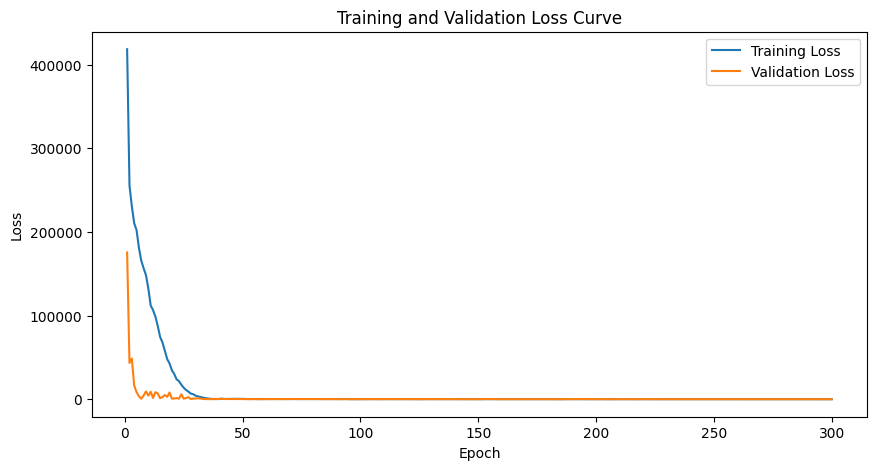

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18.324971380872327


/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
# Convert the error log to a DataFrame for further analysis
errors_df = pd.DataFrame(errors_log)
errors_df["error"] = errors_df["error"].apply(lambda x: x[0] if len(x) == 1 else x)


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_per_epoch, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss_per_epoch, label='Validation Loss')
plt.title("Training and Validation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate results
test_prediction = model.predict(test_model_input)
rmse_test = mean_squared_error(test_target, test_prediction, squared=False)
print(rmse_test)

In [28]:
laabeel = 'month' if conditioned else 'no label'
var_inputs = '' if inputs == None else ', '.join(inputs)
variables = ', '.join([var_inputs, laabeel])

details = {'Experiment':[0],'RMSE':[rmse_test],'Variables':[variables],'Input': [f'{len(np.unique(labels))} rivers'], 'Split': ['random'], \
               'nº samples': [len(data_targets)], 'Batch size': [batch_size], 'Epochs': [epochs],  \
               'Loss':  ['Physics-guided' if physics_guided else 'RMSE']}
pd.DataFrame(details)

,Experiment,RMSE,Variables,Input,Split,nº samples,Batch size,Epochs,Loss
0,0,18.324971,"lst, month",47 rivers,random,955,64,300,RMSE


In [ ]:
import pandas as pd
model_name = 'baseline_CNN'
pd.read_excel(f'../results/{model_name}_results.xlsx')

## Visualize results

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
plt.figure(figsize=(16,5))
#plt.clf
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Simpler CNN MSE Loss during training --- lst+ndvi with wt target')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.savefig('../plots/cnn.png',dpi=100)

In [ ]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE during training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Validate and test

Image wise metrics results

See what are the areas with more prediction error

In [ ]:
if len(validation_prediction.shape) == 4:
  validation_prediction=np.squeeze(validation_prediction, axis=3)

diff = validation_prediction - validation_target
for i in range(diff.shape[0]):
  sns.heatmap(diff[i], cmap='coolwarm')
  plt.title('Prediction Error Heatmap')
  plt.show()

Dispersion graph and histogram of prediction errors

In [ ]:
validation_target_flat = validation_target.reshape(-1)
validation_prediction_flat = validation_prediction.reshape(-1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que y_true son tus valores reales y y_pred son tus predicciones
y_true = validation_target_flat # Valores reales
y_pred = validation_prediction_flat  # Predicciones del modelo

# Visualización
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('True Values vs Predictions')
plt.show()

# Histograma de errores
errors = y_pred - y_true
plt.hist(errors, bins=30)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()
